<a href="https://colab.research.google.com/github/abigailvolk/cyano_ML/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read in data from my Github Repo
- Check to make sure it imports appropriately. 
- Get a list of column names with indices
- Will drop the non-transformed columns to actually run my model

In [ ]:
url = "https://raw.githubusercontent.com/abigailvolk/cyano_ML/main/WE08_16transformed.csv"
df = pd.read_csv(url)
print(df.head())
columns = df.columns.tolist()
for i, column in enumerate(columns):
    print(i, column)


   wind_speed_max  wind_speed_mean  wind_direction_mean  air_temp  \
0            6.40            5.379                126.6     20.58   
1            6.25            5.142                120.4     20.71   
2            6.45            5.513                116.6     20.51   
3            6.60            5.524                111.3     20.55   
4            7.70            6.306                 87.5     20.35   

   barometric_pressure  depth  water_temperature  specific_conductivity    pH  \
0             1013.751  1.090              22.84                  348.7  8.49   
1             1013.794  1.088              22.85                  348.7  8.49   
2             1013.298  1.081              22.85                  348.7  8.49   
3             1012.888  1.080              22.86                  348.6  8.50   
4             1011.421  1.070              22.83                  348.5  8.51   

   turbidity  ...  organic_dissolved_oxygen  chlorophylla  phycocyanin  \
0      0.992  ...       

# Drop the non-transformed columns and split the data into X and y, and training and test set
- All columns with skews have been largely transformed to be a **mostly** normal distribution (i.e. phycocyanin, turbidity, chlorophyll-a, dissolved oxygen saturation, dissolved oxygen). These were transformed with a square root transformation due to right skew. Initial distributions had skewness measuring over 1.14-2 (using skeweness function). After transformation, skewness was measuring ~1, which is still high. However, the distributions looked better.
- Uncertain about what to do with pH -- likely will be one of the best predictors and currently is not-transformed. Might be worth messing with in the future.
- Separate phycocyanin as y and everything else as X
- Create training and testing sets for X and y: conservative test set (40% of the data)

### Scale the data
- To scale the data, we need to scale the training set ALONE to avoid data leakage. Then, the transformation values will be applied to the test set. This will help prevent the test set from influencing the scaled values (data leakage)

In [ ]:
df = df.drop(["turbidity", "organic_dissolved_oxygen_saturation", "organic_dissolved_oxygen", "chlorophylla", "phycocyanin", "log_phyco"], axis=1)
df.head()

,wind_speed_max,wind_speed_mean,wind_direction_mean,air_temp,barometric_pressure,depth,water_temperature,specific_conductivity,pH,flourescent_dissolved_organic_matter,sqrt_phyco,sqrt_turb,sqrt_DOsat,sqrt_DO,sqrt_chlorophyll
0,6.40,5.379,126.6,20.58,1013.751,1.090,22.84,348.7,8.49,3.048,0.070711,0.995992,10.256705,3.008322,0.666333
1,6.25,5.142,120.4,20.71,1013.794,1.088,22.85,348.7,8.49,3.038,0.126491,0.996995,10.271319,3.011644,0.684105
2,6.45,5.513,116.6,20.51,1013.298,1.081,22.85,348.7,8.49,3.053,0.083666,1.006976,10.285913,3.016621,0.716240
3,6.60,5.524,111.3,20.55,1012.888,1.080,22.86,348.6,8.50,3.038,0.000000,0.984886,10.305338,3.021589,0.707814
4,7.70,6.306,87.5,20.35,1011.421,1.070,22.83,348.5,8.51,3.098,0.130384,1.039230,10.344080,3.034798,0.719027


In [59]:
# X is the predictors, Y is the prediction (phycocyanin)
X = df.drop("sqrt_phyco", axis=1)
y = df[["sqrt_phyco"]]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)


In [60]:
# fit the scaler based on the X training set
scaler = StandardScaler()
scaler.fit(X_train)

# Apply the scaler to the training and testing data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)



# Build/compile a base multilayer perceptron to the data
- Using a Multi-Layer Perceptron (MLP)
- Number of features is ALL data values (14)
- Minimize loss based on the mean squared error since this is a regression problem
- Optimizer is Adam, as of 2014 does a good job converging to solutions quickly



In [97]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam, RMSprop, SGD
from keras.activations import relu, sigmoid, tanh
from keras.initializers import RandomNormal, he_normal

In [65]:
num_features = len(X_train[0])
print(num_features)

14


In [94]:
# define the base model for the MLP
model = Sequential()
model.add(Dense(64, input_dim=num_features, activation="relu", kernel_initializer=he_normal()))
model.add(Dense(32, activation="relu", kernel_initializer=he_normal()))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mean_squared_error'])


In [95]:
### Fit the first model
history = model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=0)

In [96]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error'])


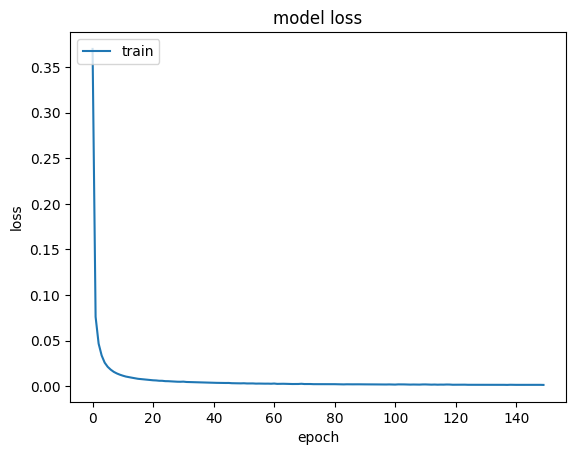

In [101]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [99]:
# Evaluate the model on the test set:
evaluation = model.evaluate(X_val, y_val, verbose=0)
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Test MSE: {mse:.4f}')


95/95 [==============================] - 0s 1ms/step
Test MSE: 0.0033


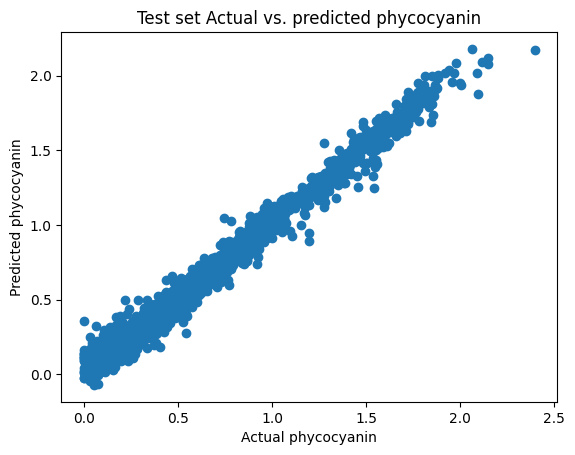

In [103]:
# Visualize the actual versus predicted
plt.scatter(y_val, y_pred)

# set axis labels and title
plt.xlabel('Actual phycocyanin')
plt.ylabel('Predicted phycocyanin')
plt.title('Test set Actual vs. predicted phycocyanin')

# show the plot
plt.show()

#**Assuming I did nothing wrong... this actually looks quite predictive....?**
- However, it is probably predicting so well because things like chlorophyll-a, turbidity, etc. are in the model. More interesting would be to see how predictive the other variables are without.
  - Based on bar graph below, pH is the best predictor, water temp is the second best. cool!
- **Also, the concept of a time based forecast relying on the previous phycocyanin/chlorophyll-a could be interesting as well.**

In [109]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


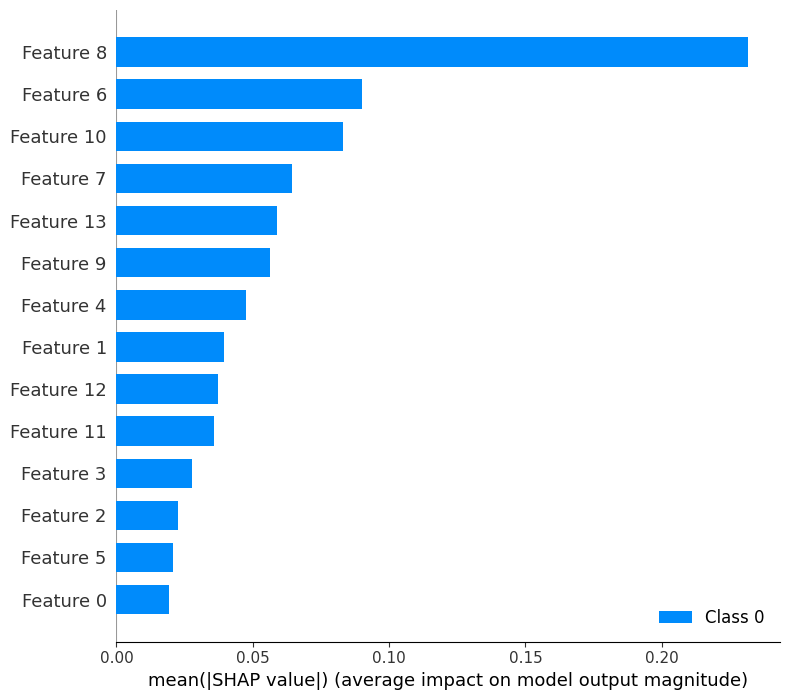

In [112]:
shap.initjs()
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_val[:100])
shap.summary_plot(shap_values, X_val, plot_type='bar')

# In progress... Tuning some hyperparameters and adjusting

In [ ]:
# def create_model(optimizer='adam', activation='relu', init='he_normal'):
#     model = Sequential()
#     model.add(Dense(64, input_dim=13, activation=activation, kernel_initializer=init))
#     model.add(Dense(32, activation=activation, kernel_initializer=init))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model

# model = KerasRegressor(build_fn=create_model, verbose=0)

# # define the grid search parameters
# batch_size = [10, 20, 40, 60, 80, 100]
# epochs = [10, 50, 100]
# optimizers = [Adam(), RMSprop(), SGD()]
# activations = [relu, sigmoid, tanh]
# inits = [RandomNormal(), he_normal()]
# param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers, activation=activations, init=inits)

# # perform the grid search using scikit-learn's GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X, y)

# # print the best hyperparameters and corresponding mean squared error
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))